<a href="https://colab.research.google.com/github/U-ohata/Rabbit_Report_2/blob/Rabbit_Report_Colaboratory/reportbox_4/3_1_simple_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 準備

## Googleドライブのマウント

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## sys.pathの設定

以下では，Googleドライブのマイドライブ直下にDNN_codeフォルダを置くことを仮定しています．必要に応じて，パスを変更してください．

In [2]:
import sys
# sys.path.append('/content/drive/My Drive/DNN_code')
sys.path.append('/content/drive/My Drive/Pythonライブラリ基礎講座/DNN_code_colab_lesson_1_2')

# simple RNN
### バイナリ加算

iters:0
Loss:0.9958051690579532
Pred:[0 0 0 0 0 0 0 0]
True:[0 1 1 1 0 0 0 0]
87 + 25 = 0
------------
iters:100
Loss:0.9368120218849406
Pred:[0 0 0 0 0 0 0 0]
True:[1 0 1 0 0 0 1 0]
67 + 95 = 0
------------
iters:200
Loss:0.9915500586819712
Pred:[0 0 0 0 0 0 0 0]
True:[1 0 1 0 0 1 1 0]
120 + 46 = 0
------------
iters:300
Loss:1.0791993445791372
Pred:[0 0 0 0 0 0 0 0]
True:[1 1 0 1 1 0 1 0]
106 + 112 = 0
------------
iters:400
Loss:1.2303379951732452
Pred:[0 0 0 0 0 0 0 0]
True:[1 1 1 1 0 1 1 1]
124 + 123 = 0
------------
iters:500
Loss:1.048179393652955
Pred:[0 0 0 0 0 0 0 0]
True:[1 0 1 1 0 1 0 0]
63 + 117 = 0
------------
iters:600
Loss:0.9475818749287517
Pred:[0 0 0 0 0 0 0 0]
True:[1 0 0 1 0 0 1 0]
116 + 30 = 0
------------
iters:700
Loss:0.9399620485853467
Pred:[0 0 0 0 0 0 0 0]
True:[0 1 0 1 0 0 1 0]
29 + 53 = 0
------------
iters:800
Loss:0.9910209990818184
Pred:[0 0 0 0 0 0 0 0]
True:[0 1 1 0 1 0 1 0]
16 + 90 = 0
------------
iters:900
Loss:1.1715291074624075
Pred:[0 0 0 0 0 0

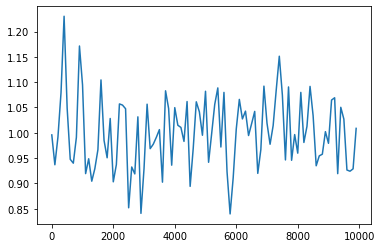

In [4]:
import numpy as np
from common import functions
import matplotlib.pyplot as plt

def d_tanh(x):
    return 1/(np.cosh(x) ** 2)


# データを用意
# 2進数の桁数
binary_dim = 8
# 最大値 + 1
largest_number = pow(2, binary_dim)
# largest_numberまで2進数を用意
binary = np.unpackbits(np.array([range(largest_number)],dtype=np.uint8).T,axis=1)

input_layer_size = 2
hidden_layer_size = 32
output_layer_size = 1

weight_init_std = 3
learning_rate = 0.2

iters_num = 10000
plot_interval = 100

# ウェイト初期化 (バイアスは簡単のため省略)
# W_in = weight_init_std * np.random.randn(input_layer_size, hidden_layer_size)
# W_out = weight_init_std * np.random.randn(hidden_layer_size, output_layer_size)
# W = weight_init_std * np.random.randn(hidden_layer_size, hidden_layer_size)

# Xavier
# W_in = np.random.randn(input_layer_size, hidden_layer_size) / (np.sqrt(input_layer_size))
# W_out = np.random.randn(hidden_layer_size, output_layer_size) / (np.sqrt(hidden_layer_size))
# W = np.random.randn(hidden_layer_size, hidden_layer_size) / (np.sqrt(hidden_layer_size))

# He
W_in = np.random.randn(input_layer_size, hidden_layer_size) / (np.sqrt(input_layer_size)) * np.sqrt(2)
W_out = np.random.randn(hidden_layer_size, output_layer_size) / (np.sqrt(hidden_layer_size)) * np.sqrt(2)
W = np.random.randn(hidden_layer_size, hidden_layer_size) / (np.sqrt(hidden_layer_size)) * np.sqrt(2)

# 勾配
W_in_grad = np.zeros_like(W_in)
W_out_grad = np.zeros_like(W_out)
W_grad = np.zeros_like(W)

u = np.zeros((hidden_layer_size, binary_dim + 1))
z = np.zeros((hidden_layer_size, binary_dim + 1))
y = np.zeros((output_layer_size, binary_dim))

delta_out = np.zeros((output_layer_size, binary_dim))
delta = np.zeros((hidden_layer_size, binary_dim + 1))

all_losses = []

for i in range(iters_num):
    
    # A, B初期化 (a + b = d)
    a_int = np.random.randint(largest_number/2)
    a_bin = binary[a_int] # binary encoding
    b_int = np.random.randint(largest_number/2)
    b_bin = binary[b_int] # binary encoding
    
    # 正解データ
    d_int = a_int + b_int
    d_bin = binary[d_int]
    
    # 出力バイナリ
    out_bin = np.zeros_like(d_bin)
    
    # 時系列全体の誤差
    all_loss = 0    
    
    # 時系列ループ
    for t in range(binary_dim):
        # 入力値
        X = np.array([a_bin[ - t - 1], b_bin[ - t - 1]]).reshape(1, -1)
        # 時刻tにおける正解データ
        dd = np.array([d_bin[binary_dim - t - 1]])
        
        u[:,t+1] = np.dot(X, W_in) + np.dot(z[:,t].reshape(1, -1), W)
        z[:,t+1] = functions.sigmoid(u[:,t+1])

        y[:,t] = functions.sigmoid(np.dot(z[:,t+1].reshape(1, -1), W_out))


        #誤差
        loss = functions.mean_squared_error(dd, y[:,t])
        
#         delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * functions.d_sigmoid(u[:,t+1])
#         delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * functions.d_relu(u[:,t+1])
        delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * d_tanh(u[:,t+1])        
        
        all_loss += loss

        out_bin[binary_dim - t - 1] = np.round(y[:,t])
    
    
    for t in range(binary_dim)[::-1]:
        X = np.array([a_bin[-t-1],b_bin[-t-1]]).reshape(1, -1)        

        delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * functions.d_sigmoid(u[:,t+1])

        # 勾配更新
        W_out_grad += np.dot(z[:,t+1].reshape(-1,1), delta_out[:,t].reshape(-1,1))
        W_grad += np.dot(z[:,t].reshape(-1,1), delta[:,t].reshape(1,-1))
        W_in_grad += np.dot(X.T, delta[:,t].reshape(1,-1))
    
    # 勾配適用
    W_in -= learning_rate * W_in_grad
    W_out -= learning_rate * W_out_grad
    W -= learning_rate * W_grad
    
    W_in_grad *= 0
    W_out_grad *= 0
    W_grad *= 0
    

    if(i % plot_interval == 0):
        all_losses.append(all_loss)        
        print("iters:" + str(i))
        print("Loss:" + str(all_loss))
        print("Pred:" + str(out_bin))
        print("True:" + str(d_bin))
        out_int = 0
        for index,x in enumerate(reversed(out_bin)):
            out_int += x * pow(2, index)
        print(str(a_int) + " + " + str(b_int) + " = " + str(out_int))
        print("------------")

lists = range(0, iters_num, plot_interval)
plt.plot(lists, all_losses, label="loss")
plt.show()

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
## [try] weight_init_stdやlearning_rate, hidden_layer_sizeを変更してみよう


## [try] 重みの初期化方法を変更してみよう
Xavier, He

## [try] 中間層の活性化関数を変更してみよう
ReLU(勾配爆発を確認しよう)<br>
tanh(numpyにtanhが用意されている。導関数をd_tanhとして作成しよう)

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

weight_init_stdを3、Learning_rateを0.2、hidden_layer_sizeを32に変更